# Normal Inverse Gamma Distribution

This notebook demonstrates the **Normal Inverse Gamma (NInvG)** distribution, a normal variance-mean mixture where the mixing distribution is Inverse Gamma.

## Mathematical Definition

The Normal Inverse Gamma distribution is defined as a normal mixture:

$$X | Y \sim N(\mu + \gamma Y, \Sigma Y)$$

$$Y \sim \text{InvGamma}(\alpha, \beta)$$

where:
- $\mu \in \mathbb{R}^d$: location parameter
- $\gamma \in \mathbb{R}^d$: skewness parameter  
- $\Sigma \in \mathbb{R}^{d \times d}$: covariance scale matrix (positive definite)
- $\alpha > 0$: Inverse Gamma shape parameter
- $\beta > 0$: Inverse Gamma rate parameter

## Key Properties

| Property | Formula | Condition |
|----------|--------|----------|
| Mean | $E[X] = \mu + \gamma \frac{\beta}{\alpha - 1}$ | $\alpha > 1$ |
| Covariance | $\text{Cov}[X] = \frac{\beta}{\alpha-1} \Sigma + \frac{\beta^2}{(\alpha-1)^2(\alpha-2)} \gamma \gamma^T$ | $\alpha > 2$ |

## Distribution Types

- **Joint distribution** $f(x, y)$: Exponential family (tractable)
- **Marginal distribution** $f(x)$: NOT exponential family (requires EM for fitting)

## Special Case

NInvG is a special case of the **Generalized Hyperbolic** distribution with GIG parameter $a \to 0$.

When $\gamma = 0$ (symmetric), NInvG is related to the **Student-t** distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats

from normix.distributions.mixtures import JointNormalInverseGamma, NormalInverseGamma
from normix.distributions.univariate import InverseGamma
from normix.utils import (
    plot_joint_distribution_1d,
    plot_marginal_distribution_2d,
    validate_moments,
    print_moment_validation,
    fit_and_track_convergence,
    plot_em_convergence,
    test_joint_fitting,
    print_fitting_results
)

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Consistent styling
COLORS = {'primary': 'tab:blue', 'secondary': 'tab:red', 'tertiary': 'tab:green'}
np.set_printoptions(precision=4, suppress=True)

## Parameter Sets for Testing

We test with three different parameter configurations to demonstrate the distribution's flexibility.

**Note:** We need $\alpha > 2$ for the variance to exist.

In [2]:
# Define three parameter sets for comprehensive testing
PARAM_SETS = [
    {
        'name': 'Symmetric (γ=0)',
        'mu': np.array([0.0, 0.0]),
        'gamma': np.array([0.0, 0.0]),
        'sigma': np.array([[1.0, 0.3], [0.3, 1.0]]),
        'shape': 3.0,  # α > 2 for finite variance
        'rate': 1.0
    },
    {
        'name': 'Right-skewed (γ>0)',
        'mu': np.array([0.0, 0.0]),
        'gamma': np.array([0.5, 0.3]),
        'sigma': np.array([[1.0, 0.2], [0.2, 1.5]]),
        'shape': 4.0,
        'rate': 2.0
    },
    {
        'name': 'Left-skewed (γ<0)',
        'mu': np.array([1.0, -0.5]),
        'gamma': np.array([-0.4, 0.2]),
        'sigma': np.array([[2.0, -0.5], [-0.5, 1.0]]),
        'shape': 5.0,
        'rate': 1.5
    }
]

# Display parameter sets
for i, params in enumerate(PARAM_SETS):
    print(f"\nParameter Set {i+1}: {params['name']}")
    print(f"  μ = {params['mu']}")
    print(f"  γ = {params['gamma']}")
    print(f"  α = {params['shape']}, β = {params['rate']}")


Parameter Set 1: Symmetric (γ=0)
  μ = [0. 0.]
  γ = [0. 0.]
  α = 3.0, β = 1.0

Parameter Set 2: Right-skewed (γ>0)
  μ = [0. 0.]
  γ = [0.5 0.3]
  α = 4.0, β = 2.0

Parameter Set 3: Left-skewed (γ<0)
  μ = [ 1.  -0.5]
  γ = [-0.4  0.2]
  α = 5.0, β = 1.5


---
# Part 1: Joint Distribution (1D X)

The joint distribution $f(x, y)$ is an **exponential family** with natural parameters.

In [3]:
def get_1d_params(params):
    """Extract 1D version of parameters."""
    return {
        'mu': np.array([params['mu'][0]]),
        'gamma': np.array([params['gamma'][0]]),
        'sigma': np.array([[params['sigma'][0, 0]]]),
        'shape': params['shape'],
        'rate': params['rate']
    }

## 1.1 Joint Distribution Visualization


Parameter Set 1: Symmetric (γ=0)


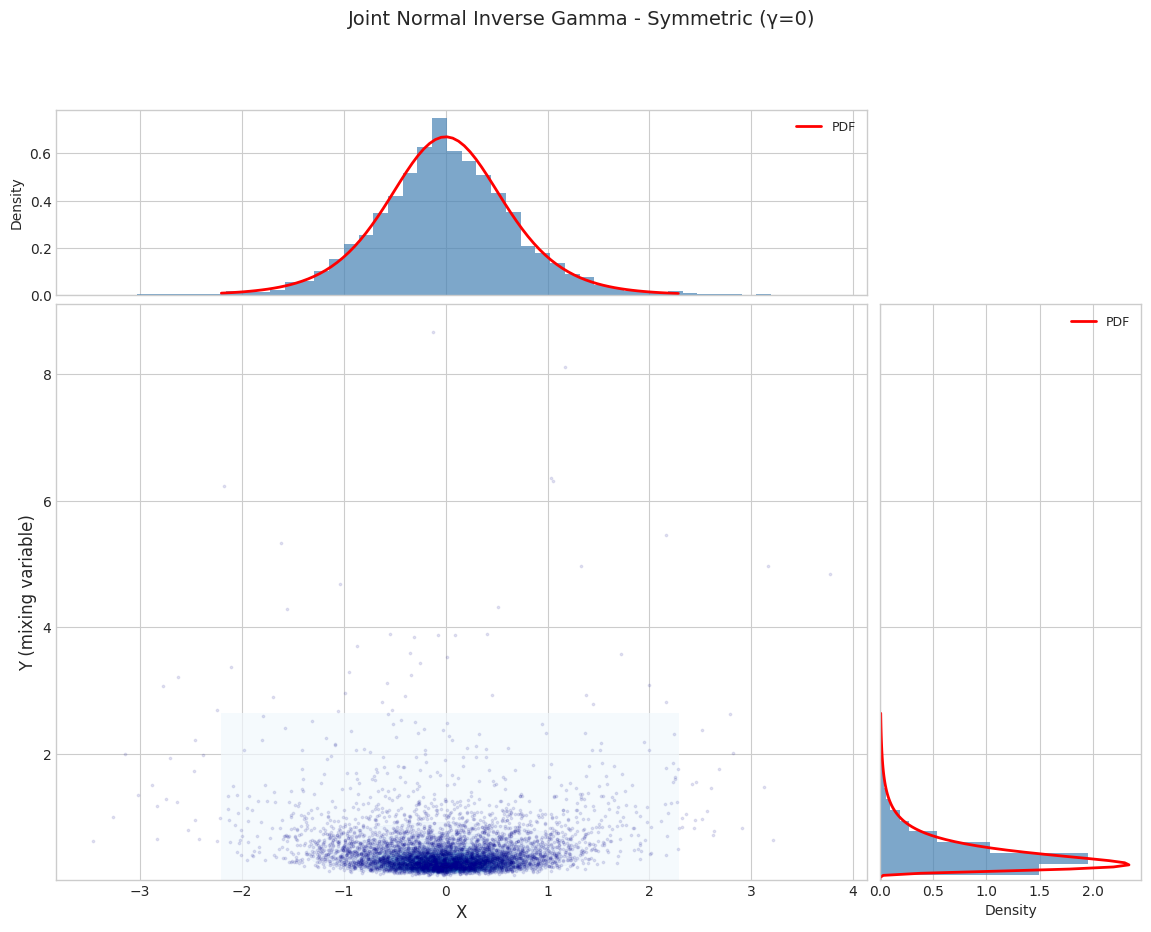


Parameter Set 2: Right-skewed (γ>0)


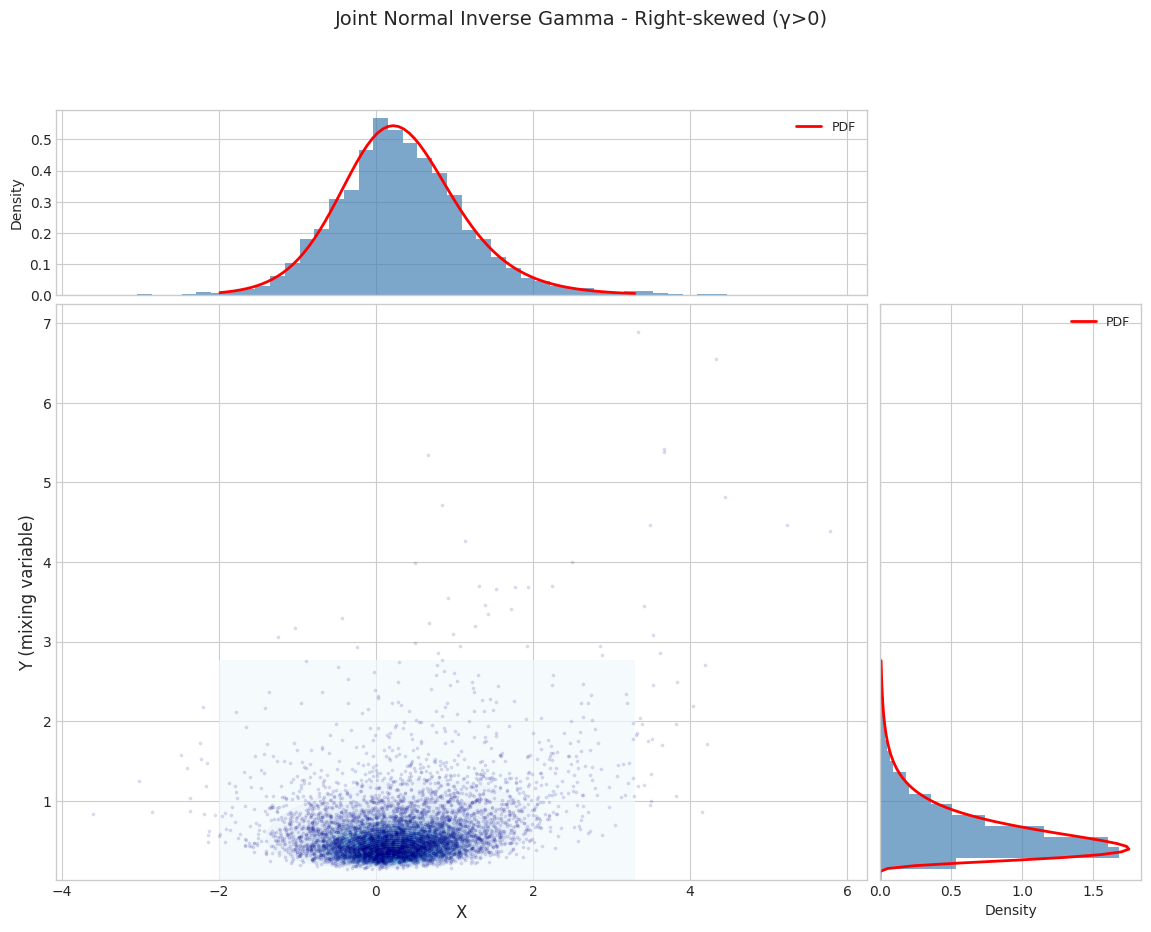


Parameter Set 3: Left-skewed (γ<0)


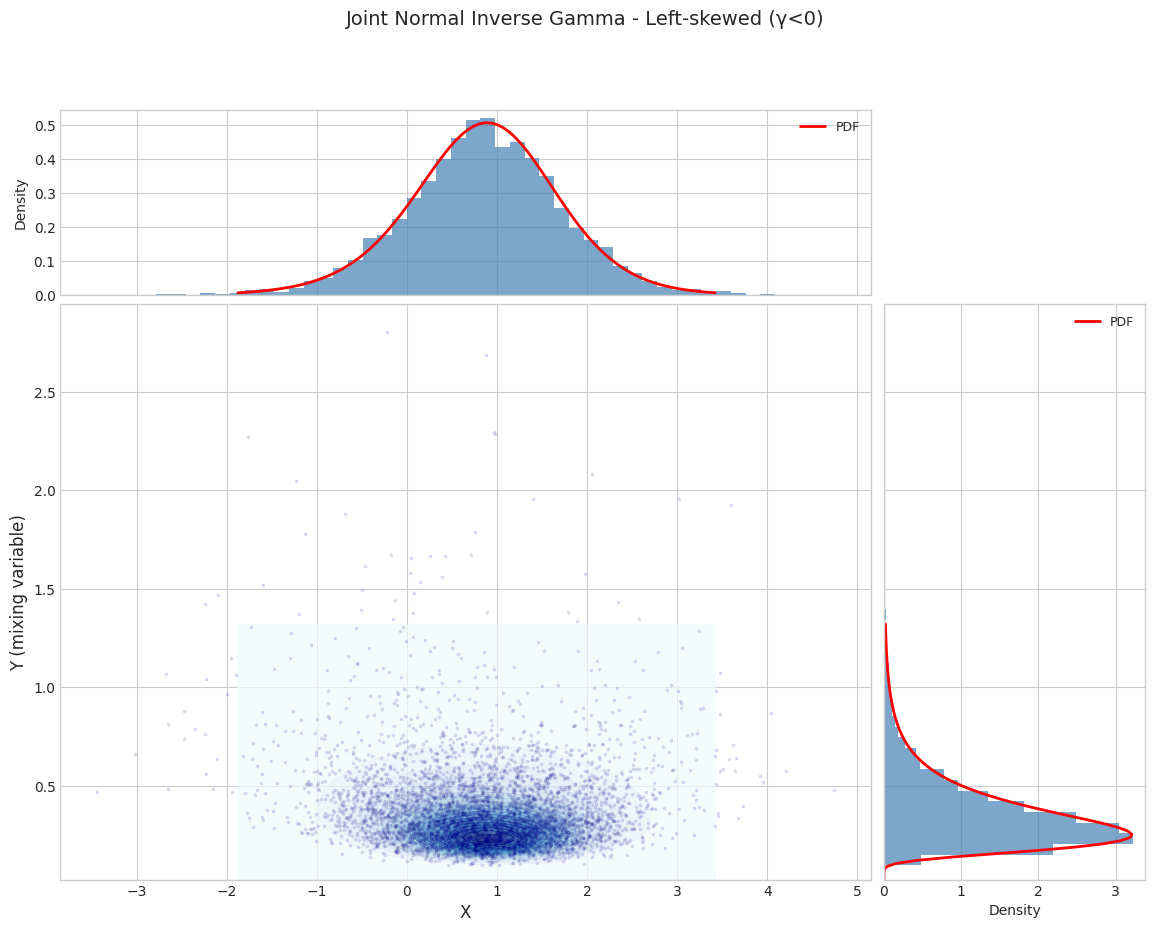

In [4]:
N_SAMPLES = 5000

for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    joint_dist = JointNormalInverseGamma.from_classical_params(**params_1d)
    
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    fig = plot_joint_distribution_1d(
        joint_dist, 
        n_samples=N_SAMPLES, 
        random_state=42,
        title=f"Joint Normal Inverse Gamma - {params['name']}"
    )
    plt.show()

## 1.2 Moment Validation (Joint)

In [5]:
for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    joint_dist = JointNormalInverseGamma.from_classical_params(**params_1d)
    
    results = validate_moments(joint_dist, n_samples=50000, random_state=42, is_joint=True)
    print_moment_validation(results, f"Joint NInvG - {params['name']}")


Moment Validation: Joint NInvG - Symmetric (γ=0)
X_mean    : sample =    -0.0060, theory =     0.0000, rel_err = 6.03e+07
Y_mean    : sample =     0.5012, theory =     0.5000, rel_err = 2.39e-03
X_var     : sample =     0.5016, theory =     0.5000, rel_err = 3.12e-03
Y_var     : sample =     0.2557, theory =     0.2500, rel_err = 2.27e-02

Moment Validation: Joint NInvG - Right-skewed (γ>0)
X_mean    : sample =     0.3268, theory =     0.3333, rel_err = 1.96e-02
Y_mean    : sample =     0.6677, theory =     0.6667, rel_err = 1.60e-03
X_var     : sample =     0.7274, theory =     0.7222, rel_err = 7.17e-03
Y_var     : sample =     0.2266, theory =     0.2222, rel_err = 1.99e-02

Moment Validation: Joint NInvG - Left-skewed (γ<0)
X_mean    : sample =     0.8423, theory =     0.8500, rel_err = 9.09e-03
Y_mean    : sample =     0.3755, theory =     0.3750, rel_err = 1.28e-03
X_var     : sample =     0.7622, theory =     0.7575, rel_err = 6.23e-03
Y_var     : sample =     0.0475, theory = 

## 1.3 Joint Distribution Fitting (Exponential Family MLE)

In [6]:
for i, params in enumerate(PARAM_SETS):
    params_1d = get_1d_params(params)
    
    fitted_dist, fitted_params, param_errors = test_joint_fitting(
        JointNormalInverseGamma, 
        params_1d, 
        n_samples=N_SAMPLES, 
        random_state=42
    )
    print_fitting_results(params_1d, fitted_params, param_errors, f"Joint NInvG - {params['name']}")


Fitting Results: Joint NInvG - Symmetric (γ=0)
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000         -0.0147     1.47e+08
gamma                    0.0000          0.0328     3.28e+08
sigma                    1.0000          1.0242     2.42e-02
shape                    3.0000          3.0147     4.90e-03
rate                     1.0000          0.9999     9.66e-05

Fitting Results: Joint NInvG - Right-skewed (γ>0)
Parameter                  True          Fitted    Rel.Error
------------------------------------------------------------
mu                       0.0000         -0.0209     2.09e+08
gamma                    0.5000          0.5333     6.65e-02
sigma                    1.0000          1.0242     2.42e-02
shape                    4.0000          4.0180     4.50e-03
rate                     2.0000          2.0000     2.17e-05

Fitting Results: Joint NInvG - Left-skewed (γ<

---
# Part 2: Marginal Distribution (2D X)

The marginal distribution $f(x) = \int f(x, y) dy$ is **NOT** an exponential family.

Fitting requires the **EM algorithm**.

## 2.1 Marginal Distribution Visualization


Parameter Set 1: Symmetric (γ=0)


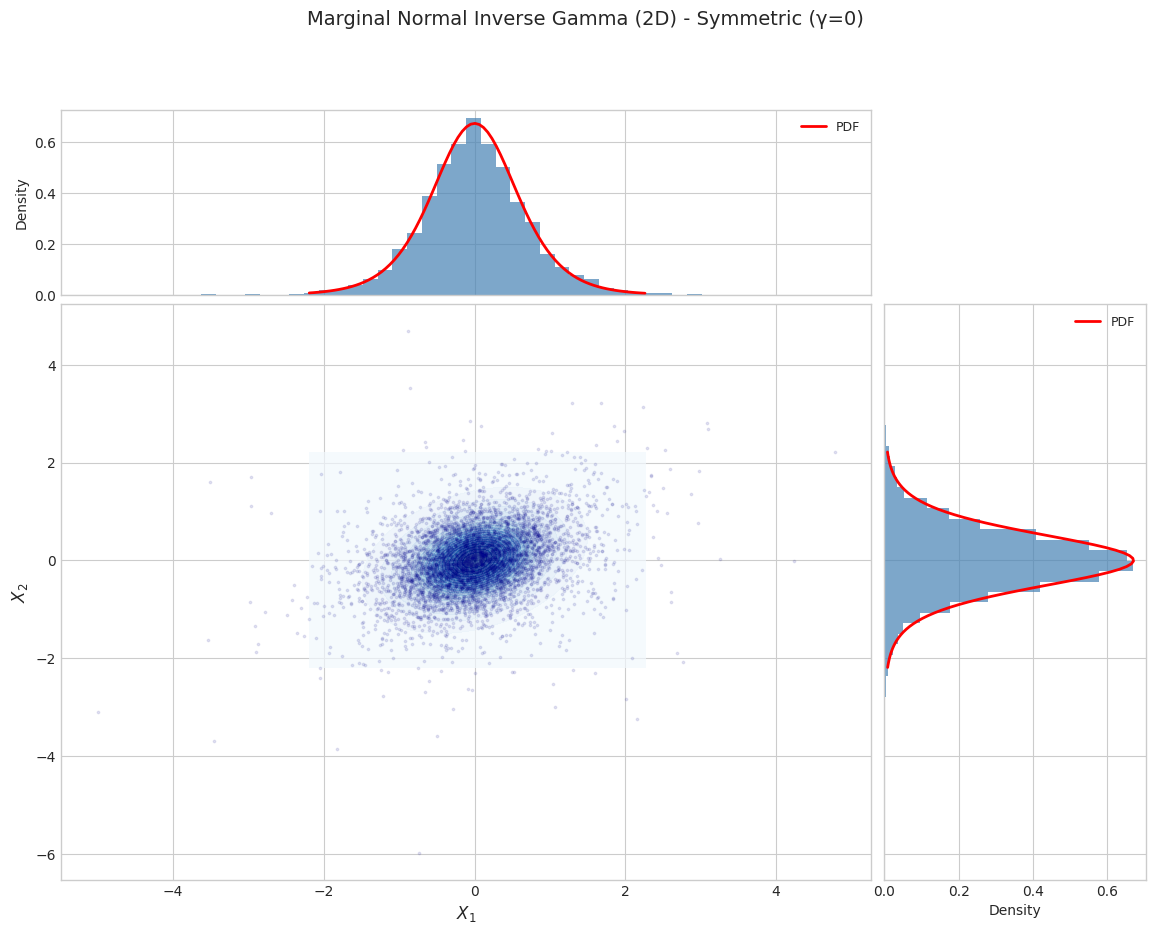


Parameter Set 2: Right-skewed (γ>0)


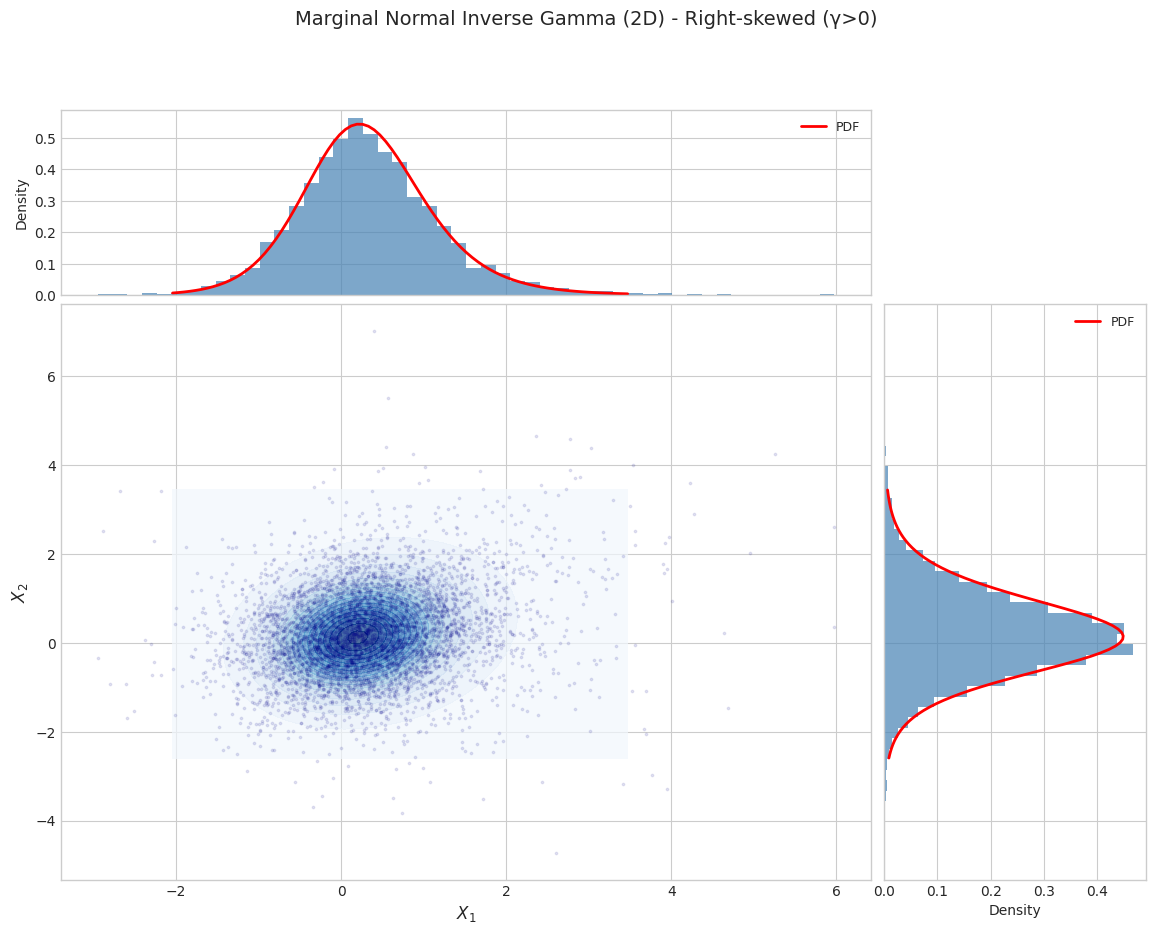


Parameter Set 3: Left-skewed (γ<0)


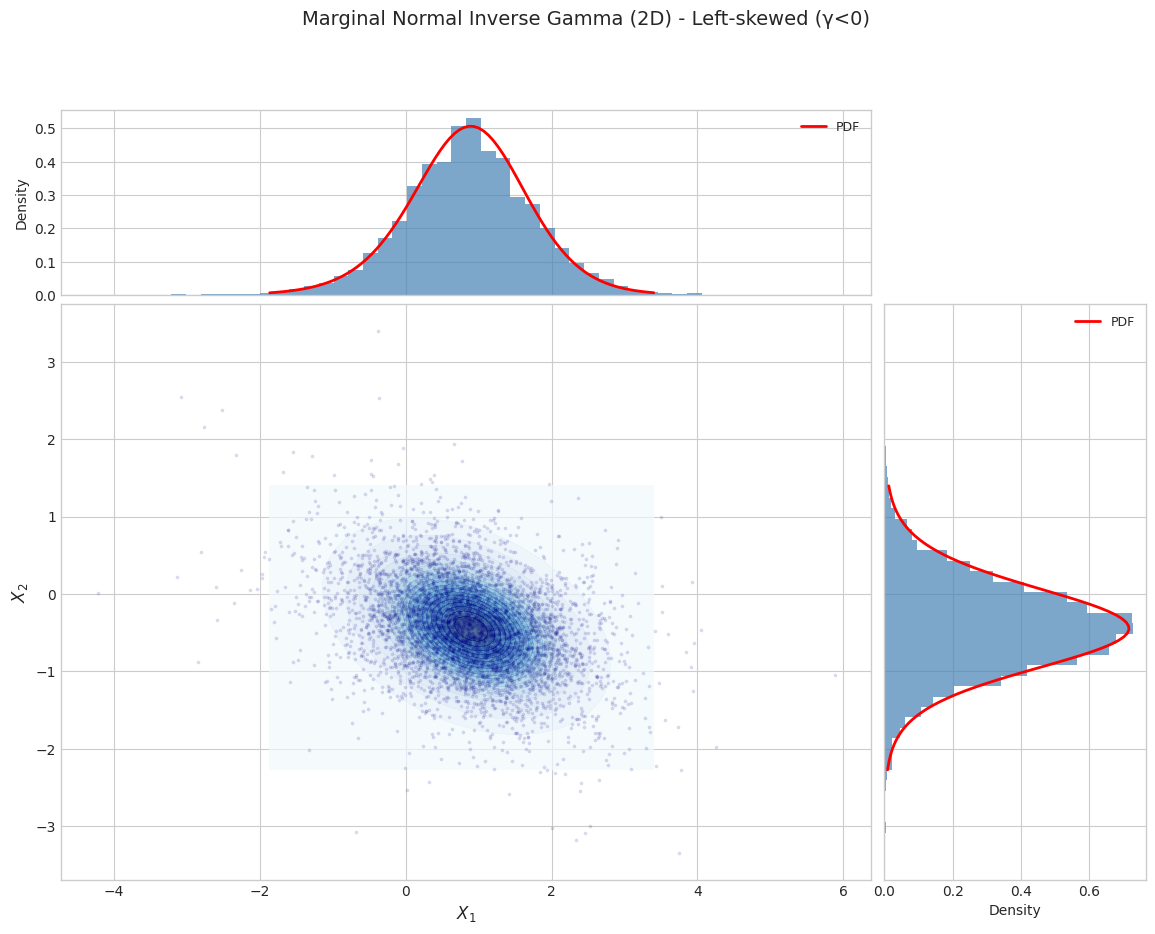

In [7]:
for i, params in enumerate(PARAM_SETS):
    marginal_dist = NormalInverseGamma.from_classical_params(**params)
    
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    fig = plot_marginal_distribution_2d(
        marginal_dist, 
        n_samples=N_SAMPLES, 
        random_state=42,
        title=f"Marginal Normal Inverse Gamma (2D) - {params['name']}"
    )
    plt.show()

## 2.2 Moment Validation (Marginal)

In [8]:
for i, params in enumerate(PARAM_SETS):
    marginal_dist = NormalInverseGamma.from_classical_params(**params)
    
    results = validate_moments(marginal_dist, n_samples=50000, random_state=42, is_joint=False)
    print_moment_validation(results, f"Marginal NInvG - {params['name']}")


Moment Validation: Marginal NInvG - Symmetric (γ=0)
mean      :
  sample = [-0.0077 -0.0051]
  theory = [0. 0.]
  rel_err = [77307132.17 51282875.38]
variance  :
  sample = [0.5132 0.5074]
  theory = [0.5 0.5]
  rel_err = [0.03 0.01]

Moment Validation: Marginal NInvG - Right-skewed (γ>0)
mean      :
  sample = [0.3252 0.195 ]
  theory = [0.3333 0.2   ]
  rel_err = [0.02 0.03]
variance  :
  sample = [0.7318 1.0234]
  theory = [0.7222 1.02  ]
  rel_err = [0.01 0.  ]

Moment Validation: Marginal NInvG - Left-skewed (γ<0)
mean      :
  sample = [ 0.8409 -0.4246]
  theory = [ 0.85  -0.425]
  rel_err = [0.01 0.  ]
variance  :
  sample = [0.7763 0.3804]
  theory = [0.7575 0.3769]
  rel_err = [0.02 0.01]


## 2.3 EM Algorithm Fitting with Convergence Tracking


Parameter Set 1: Symmetric (γ=0)

Converged: True
Iterations: 25
Initial LL: -2.0314
Final LL:   -2.0305

Parameter Comparison:
  True α = 3.0000, Fitted α = 2.7743
  True β = 1.0000, Fitted β = 0.9147


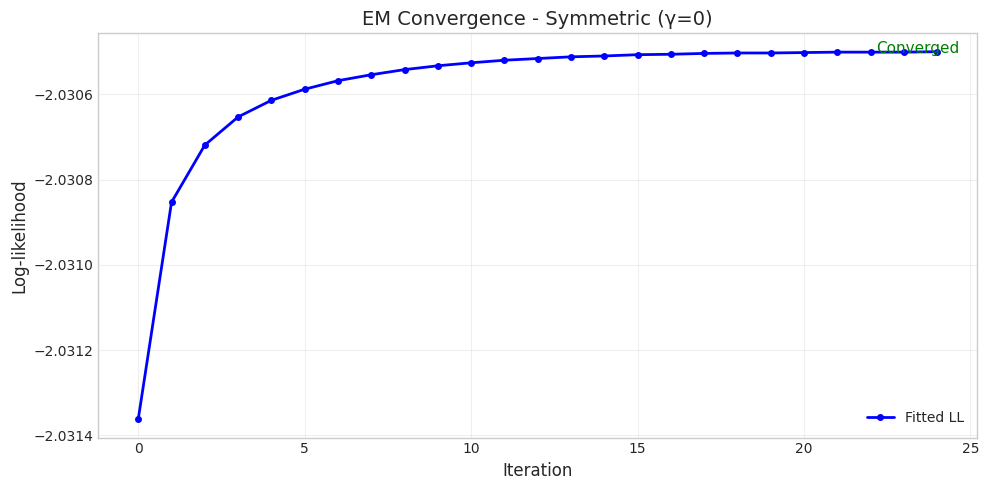


Parameter Set 2: Right-skewed (γ>0)

Converged: True
Iterations: 68
Initial LL: -2.6262
Final LL:   -2.6144

Parameter Comparison:
  True α = 4.0000, Fitted α = 3.5385
  True β = 2.0000, Fitted β = 1.1895


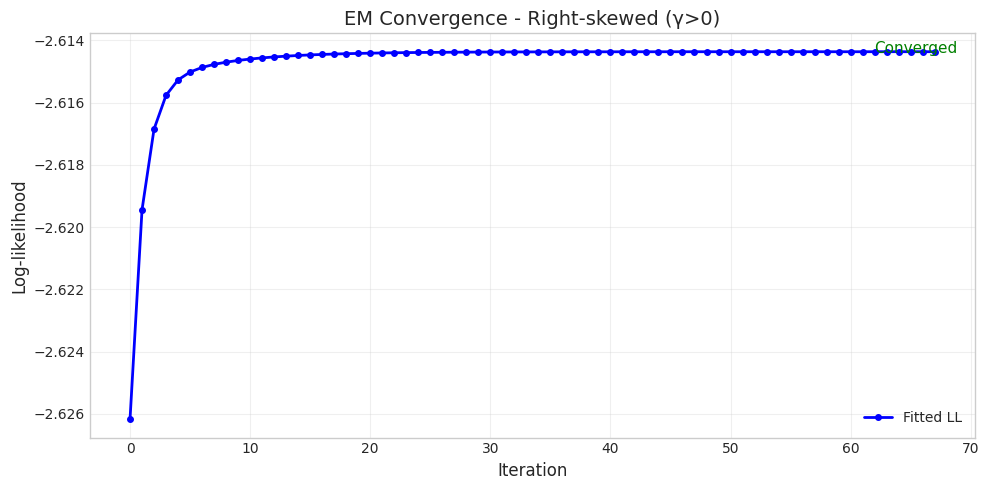


Parameter Set 3: Left-skewed (γ<0)

Converged: True
Iterations: 55
Initial LL: -2.1243
Final LL:   -2.1185

Parameter Comparison:
  True α = 5.0000, Fitted α = 4.4515
  True β = 1.5000, Fitted β = 1.5368


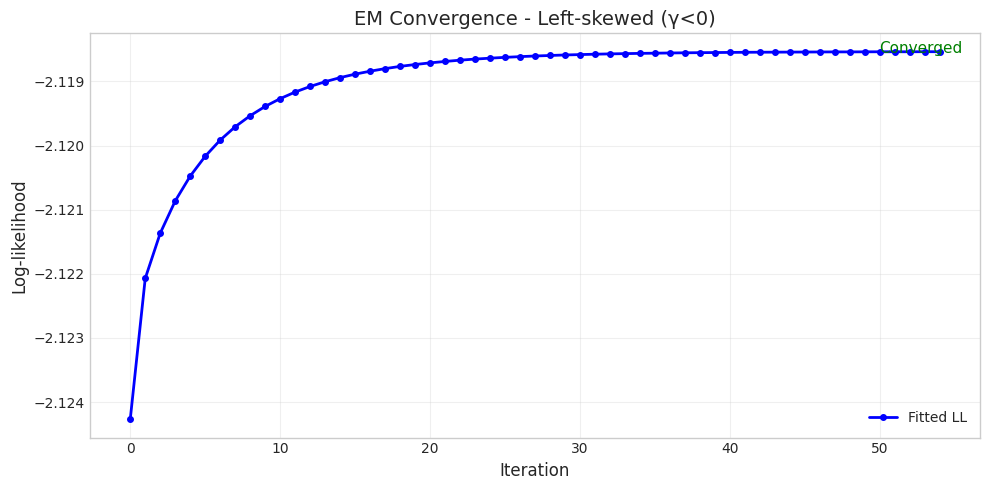

In [9]:
for i, params in enumerate(PARAM_SETS):
    print(f"\n{'='*70}")
    print(f"Parameter Set {i+1}: {params['name']}")
    print(f"{'='*70}")
    
    # Generate data from true distribution
    true_dist = NormalInverseGamma.from_classical_params(**params)
    X_data = true_dist.rvs(size=N_SAMPLES, random_state=42)
    
    # Fit with EM and track convergence
    fitted_dist, convergence = fit_and_track_convergence(
        NormalInverseGamma, 
        X_data, 
        max_iter=100, 
        random_state=43
    )
    
    # Print results
    print(f"\nConverged: {convergence.converged}")
    print(f"Iterations: {len(convergence.iterations)}")
    if convergence.log_likelihoods:
        print(f"Initial LL: {convergence.log_likelihoods[0]:.4f}")
        print(f"Final LL:   {convergence.log_likelihoods[-1]:.4f}")
    
    # Compare parameters
    print("\nParameter Comparison:")
    print(f"  True α = {params['shape']:.4f}, Fitted α = {convergence.final_params['shape']:.4f}")
    print(f"  True β = {params['rate']:.4f}, Fitted β = {convergence.final_params['rate']:.4f}")
    
    # Plot convergence
    if convergence.iterations:
        fig = plot_em_convergence(
            convergence,
            title=f"EM Convergence - {params['name']}"
        )
        plt.show()

---
# Part 3: Exponential Family Structure

The joint distribution has the exponential family form:

$$f(x, y | \theta) = h(x, y) \exp(\theta^T t(x, y) - \psi(\theta))$$

In [11]:
# Demonstrate exponential family structure
params_1d = get_1d_params(PARAM_SETS[1])  # Use right-skewed set
joint_dist = JointNormalInverseGamma.from_classical_params(**params_1d)

print("Exponential Family Structure")
print("="*60)
print(f"\nClassical parameters:")
print(joint_dist.classical_params)

print(f"\nNatural parameters θ:")
print(joint_dist.natural_params)

print(f"\nExpectation parameters η = E[t(X,Y)]:")
print(joint_dist.expectation_params)

Exponential Family Structure

Classical parameters:
{'mu': array([0.]), 'gamma': array([0.5]), 'sigma': array([[1.]]), 'shape': np.float64(4.0), 'rate': np.float64(2.0)}

Natural parameters θ:
[-5.5   -2.    -0.125  0.5    0.    -0.5  ]

Expectation parameters η = E[t(X,Y)]:
[-0.563   2.      0.6667  0.3333  0.5     1.1667]


In [13]:
# Verify E[t(X,Y)] matches expectation parameters
X_samples, Y_samples = joint_dist.rvs(size=50000, random_state=42)
t_samples = joint_dist._sufficient_statistics(X_samples, Y_samples)

eta_sample = np.mean(t_samples, axis=0)
eta_theory = joint_dist.expectation_params

print("\nVerification: E[t(X,Y)] from samples vs theory")
print("="*60)
print(f"Sample:     {eta_sample}")
print(f"Theory:     {eta_theory}")
print(f"Max error:  {np.max(np.abs(eta_sample - eta_theory)):.6f}")


Verification: E[t(X,Y)] from samples vs theory
Sample:     [-0.5618  1.9985  0.6677  0.3268  0.4892  1.1688]
Theory:     [-0.563   2.      0.6667  0.3333  0.5     1.1667]
Max error:  0.010790


---
# Part 4: Connection to Student-t (Symmetric Case)

When $\gamma = 0$, the NInvG distribution is symmetric and related to the Student-t distribution.

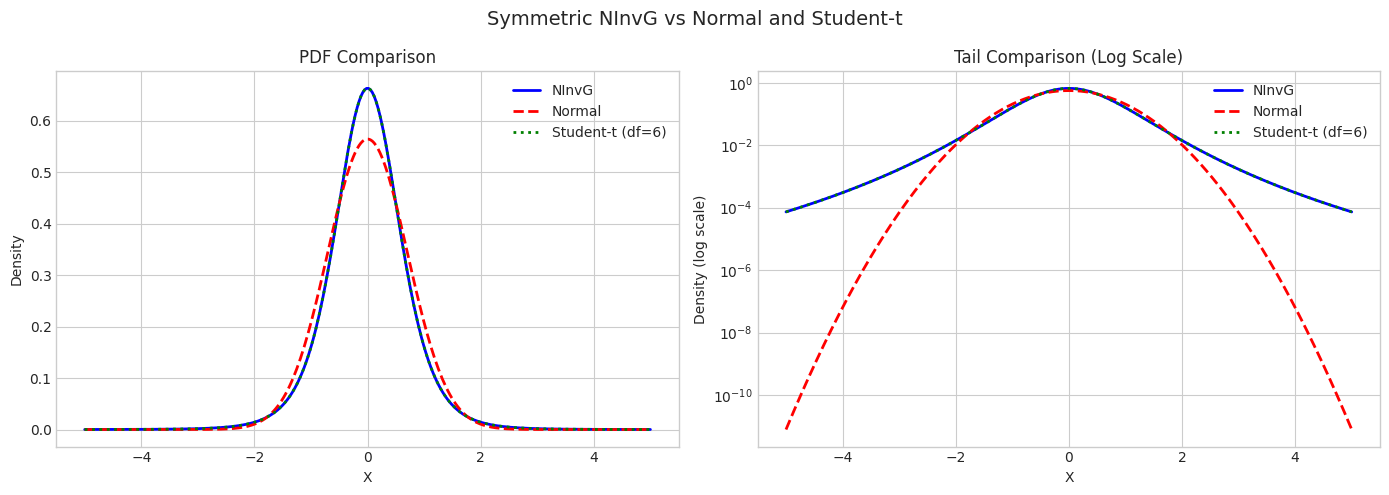


NInvG: mean = 0.0000, var = 0.5000
Sample kurtosis: 2.3420 (normal = 0)


In [14]:
# Compare symmetric NInvG with Normal and Student-t
params_sym = PARAM_SETS[0]  # Symmetric case
ninvg = NormalInverseGamma.from_classical_params(
    mu=np.array([0.0]),
    gamma=np.array([0.0]),
    sigma=np.array([[1.0]]),
    shape=3.0,
    rate=1.0
)

# Sample and compute statistics
samples = ninvg.rvs(size=50000, random_state=42)

# Compare with Normal and Student-t
ninvg_mean = ninvg.mean()[0]
ninvg_var = ninvg.var()[0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_range = np.linspace(-5, 5, 300)

# PDF comparison
ninvg_pdf = ninvg.pdf(x_range.reshape(-1, 1)).flatten()
normal_pdf = stats.norm(loc=ninvg_mean, scale=np.sqrt(ninvg_var)).pdf(x_range)
# Student-t with df = 2α for comparison
t_pdf = stats.t(df=6, loc=ninvg_mean, scale=np.sqrt(ninvg_var * 4/6)).pdf(x_range)

axes[0].plot(x_range, ninvg_pdf, 'b-', linewidth=2, label='NInvG')
axes[0].plot(x_range, normal_pdf, 'r--', linewidth=2, label='Normal')
axes[0].plot(x_range, t_pdf, 'g:', linewidth=2, label='Student-t (df=6)')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Density')
axes[0].set_title('PDF Comparison')
axes[0].legend()

# Log-scale for tails
axes[1].semilogy(x_range, ninvg_pdf, 'b-', linewidth=2, label='NInvG')
axes[1].semilogy(x_range, normal_pdf, 'r--', linewidth=2, label='Normal')
axes[1].semilogy(x_range, t_pdf, 'g:', linewidth=2, label='Student-t (df=6)')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Density (log scale)')
axes[1].set_title('Tail Comparison (Log Scale)')
axes[1].legend()

plt.suptitle('Symmetric NInvG vs Normal and Student-t', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nNInvG: mean = {ninvg_mean:.4f}, var = {ninvg_var:.4f}")
print(f"Sample kurtosis: {stats.kurtosis(samples.flatten()):.4f} (normal = 0)")

---
# Summary

The **Normal Inverse Gamma** distribution is a flexible model with:

| Feature | Description |
|---------|-------------|
| Mixing | $Y \sim \text{InvGamma}(\alpha, \beta)$ |
| Skewness | Controlled by $\gamma$ |
| Tail behavior | Heavy tails (Student-t like when $\gamma=0$) |
| Joint fitting | Exponential family MLE |
| Marginal fitting | EM algorithm |
| Constraints | $\alpha > 1$ for mean, $\alpha > 2$ for variance |